**Data in Finance**

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fbourgey/fre-gy-7773-mlfe/blob/main/02_data_finance.ipynb)

Import the relevant libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import pandas_datareader.data as web
import yfinance as yf
from scipy import stats
import seaborn as sns

sns.set_theme("talk")
sns.set_style("whitegrid")
mpl.rcParams["figure.figsize"] = (8, 6)

Let us start by reviewing the different types of data we encounter in finance:

## Market Data

**Prices**: 

- Historical and real-time prices of financial instruments (stocks, bonds, commodities, etc.).


**Volume**: 

- Trading volumes indicating the number of shares or contracts traded.

- If 1,000 shares of a stock are traded today, the volume for that stock is 
1,000 (not 2,000, since each share is bought by one party and sold by another).

- Every recorded trade is recorded with price, volume, and timestamp.

<img src="figures/price_volume.png" width="800">

Source: [TradingView](https://www.tradingview.com/chart/TSLA/brOlhaL2-Using-Volume-to-Validate-Market-Moves/)

**Order Books**: 

- Lists of buy and sell orders for a particular security or financial instrument.

<img src="figures/order_book.jpg" width="800">

Source: [FXSSI](https://fxssi.com/stock-exchange-order-book-exist-forex-market)

## Derived Data

**Returns**: 

- Measures the percentage change in price over a specified period

- Let $S_t$ be the price of an asset at time $t$.


  - Simple return: 
    $$
    R_t = \frac{S_t - S_{t-1}}{S_{t-1}}
    $$
  - Log return:
    $$
    r_t = \log S_t - \log S_{t-1} = \log(1 + R_t)
    $$
  
  - Note that if $R_t$ small, then $r_t \approx R_t$ since $\log(1 + x) \approx x$ for small $x$.

- Multi-period log returns on $[t,T]$ are <span style="color:red">additive</span>: 

$$
    r_{t,T} = \sum_{u=t+1}^T r_u
$$

- Simple returns are not <span style="color:red">additive</span>:

$$
    R_{t,T} = \frac{S_T - S_t}{S_t} = \prod_{u=t+1}^T (1 + R_u) - 1 \neq \sum_{u=t+1}^T R_u
$$

**Realized Volatility**:
- A measure of the variability of asset returns over a specified period:
$$
    \mathrm{RV}_{t,T} = \sqrt{\sum_{u=t+1}^T r_u^2}
$$

**Moving Averages**:
- A smoothed version of price data to identify trends:

$$
    \mathrm{MA}_t = \frac{1}{N} \sum_{i=0}^{N-1} S_{t-i}
$$

**Yield Curves**:
- Graphs showing the relationship between interest rates and different maturities.

We retrive US yield curve data from [FRED](https://fred.stlouisfed.org/)

In [2]:
start = dt.datetime(2026, 1, 20)
end = dt.datetime(2026, 1, 22)

# Constant-maturity Treasury series from FRED
fred_tickers = [
    "DGS1MO",
    "DGS3MO",
    "DGS6MO",
    "DGS1",
    "DGS2",
    "DGS3",
    "DGS5",
    "DGS7",
    "DGS10",
    "DGS20",
    "DGS30",
]

n_mats = len(fred_tickers)

yields = pd.concat(
    [web.DataReader(t, "fred", start, end) for t in fred_tickers], axis=1
)
df_yields = yields.dropna()
df_yields.columns = fred_tickers
df_yields /= 100.0  # convert to decimals

In [3]:
df_yields

,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS7,DGS10,DGS20,DGS30
DATE,,,,,,,,,,,
2026-01-20,0.0375,0.0370,0.0361,0.0353,0.0360,0.0368,0.0386,0.0408,0.0430,0.0487,0.0491
2026-01-21,0.0375,0.0370,0.0362,0.0353,0.0360,0.0366,0.0383,0.0404,0.0426,0.0482,0.0487
2026-01-22,0.0379,0.0371,0.0361,0.0353,0.0361,0.0368,0.0385,0.0405,0.0426,0.0479,0.0484


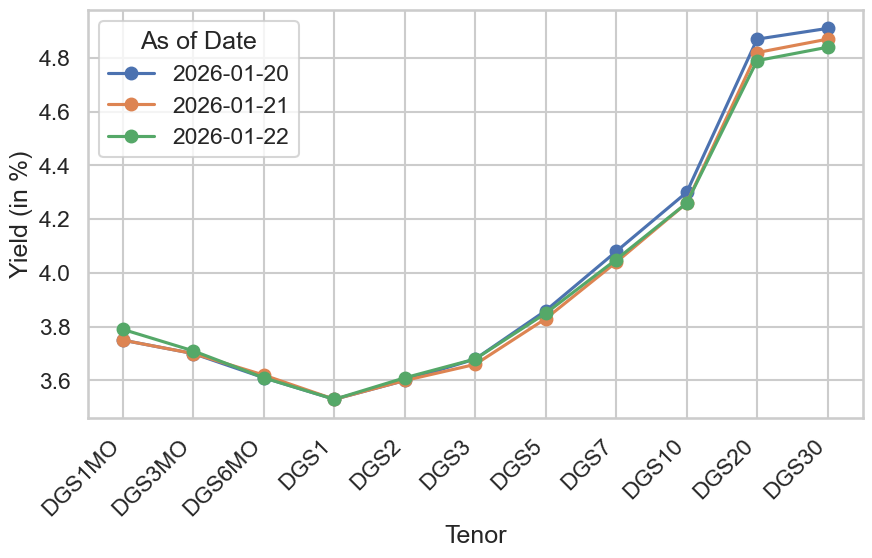

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
for date in df_yields.index:
    ax.plot(
        fred_tickers,
        100 * df_yields.loc[date].values,
        marker="o",
        label=date.strftime("%Y-%m-%d"),
    )
ax.set_xlabel("Tenor")
ax.set_ylabel("Yield (in %)")
ax.legend(title="As of Date")
fig.autofmt_xdate(rotation=45)
plt.show()

## <span style="color:green">Fundamental Data</span>


**Balance Sheets**:
- Financial statements that provide a snapshot of a company's financial position at a specific point in time.

**Earnings Reports**:
- Quarterly or annual reports that detail a company's financial performance, including revenue, expenses, and profits

**Economic Indicators**:
- Macroeconomic data such as GDP, unemployment rates, inflation rates, etc.

Let us retrieve some macro data using pandas-datareader.
We retrieve GDP data from [FRED](https://fred.stlouisfed.org/).

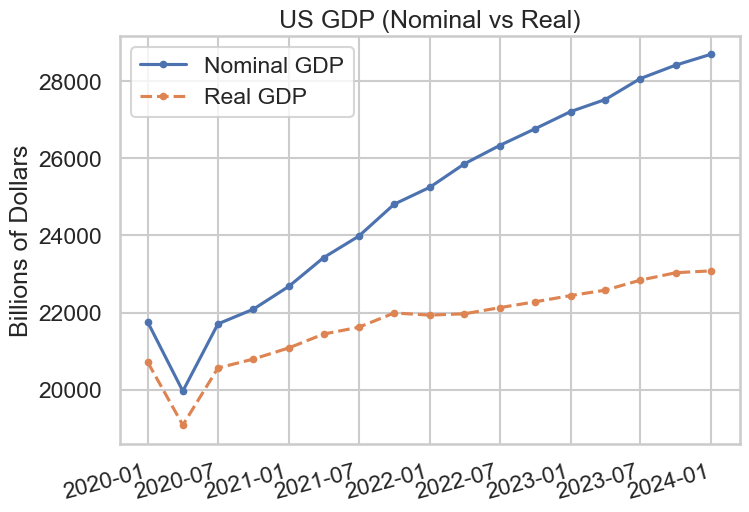

In [5]:
# GDP: GDP https://fred.stlouisfed.org/series/GDP
# Real GDP: GDPC1 https://fred.stlouisfed.org/series/GDPC1

start = dt.datetime(2020, 1, 1)
end = dt.datetime(2024, 1, 1)
gdp = web.DataReader(["GDP", "GDPC1"], "fred", start, end)
gdp = gdp.rename(columns={"GDP": "Nominal GDP", "GDPC1": "Real GDP"})

fig, ax = plt.subplots()
ax.plot(gdp.index, gdp["Nominal GDP"], ".-", label="Nominal GDP")
ax.plot(gdp.index, gdp["Real GDP"], ".--", label="Real GDP")
ax.set_title("US GDP (Nominal vs Real)")
ax.set_ylabel("Billions of Dollars")
ax.legend()
fig.autofmt_xdate(rotation=15)
plt.show()

See also, [CPI](https://fred.stlouisfed.org/series/CPIAUCSL), [Unemployment Rate](https://fred.stlouisfed.org/series/UNRATE), etc.

For a full list of available datasets, see [FRED](https://fred.stlouisfed.org/).

## Alternative Data

**News Sentiment**:
- Analysis of news articles and social media to gauge market sentiment.

**Satellite Imagery**:
- Data from satellite images to monitor activities such as retail foot traffic or agricultural output.

**ESG Data**:
- Environmental, Social, and Governance metrics used to assess a company's sustainability and ethical impact.

**Web Traffic**:
- Data on website visits and user engagement to infer consumer interest and behavior.

# Stylized Facts about Financial Data

We perform a statistical analysis of daily returns.

1) Define the tickers and timeframe

[^GSPC is the S&P 500 Index](https://finance.yahoo.com/quote/%5EGSPC/)

2) Load data

In [6]:
# Download S&P 500 data from Yahoo Finance and save to CSV

try:
    spx_data = pd.read_csv("data/spx_data.csv", index_col=0, parse_dates=True)
    print(">>>> Loaded S&P 500 data from local CSV file.")
except FileNotFoundError:
    data_yf = yf.download(["^GSPC"], start="1950-01-01", end="2026-01-26")
    spx_data = data_yf.copy()
    spx_data.columns = spx_data.columns.droplevel(1)
    spx_data.columns.name = "SPX Index"
    spx_data.to_csv("data/spx_data.csv")
    print(">>>> Downloaded S&P 500 data from Yahoo Finance.")
except Exception as e:
    raise e

spx_data = spx_data.dropna()

>>>> Loaded S&P 500 data from local CSV file.


Let us take a look at the dataset

In [7]:
print(spx_data.columns)  # Columns

Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


In [8]:
print(spx_data.index)  # Date index

DatetimeIndex(['1950-01-03', '1950-01-04', '1950-01-05', '1950-01-06',
               '1950-01-09', '1950-01-10', '1950-01-11', '1950-01-12',
               '1950-01-13', '1950-01-16',
               ...
               '2026-01-09', '2026-01-12', '2026-01-13', '2026-01-14',
               '2026-01-15', '2026-01-16', '2026-01-20', '2026-01-21',
               '2026-01-22', '2026-01-23'],
              dtype='datetime64[ns]', name='Date', length=19136, freq=None)


In [9]:
print(f"There are {spx_data.shape[0]} dates and {spx_data.shape[1]} variables.\n")
print(
    f"The first date is {spx_data.index[0].date()} and the last "
    f"date is {spx_data.index[-1].date()}."
)

There are 19136 dates and 5 variables.

The first date is 1950-01-03 and the last date is 2026-01-23.


In [10]:
spx_data.head()  # First 5 rows

,Close,High,Low,Open,Volume
Date,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000
1950-01-04,16.85,16.85,16.85,16.85,1890000
1950-01-05,16.93,16.93,16.93,16.93,2550000
1950-01-06,16.98,16.98,16.98,16.98,2010000
1950-01-09,17.08,17.08,17.08,17.08,2520000


In [11]:
spx_data.tail()  # Last 5 rows

,Close,High,Low,Open,Volume
Date,,,,,
2026-01-16,6940.009766,6967.299805,6925.089844,6960.540039,5356550000
2026-01-20,6796.859863,6871.169922,6789.049805,6865.240234,5769500000
2026-01-21,6875.620117,6910.390137,6804.959961,6810.709961,5835520000
2026-01-22,6913.350098,6934.750000,6893.620117,6914.439941,5307580000
2026-01-23,6915.609863,6932.959961,6895.500000,6907.850098,4871930000


In [12]:
spx_data.describe()  # Summary statistics

,Close,High,Low,Open,Volume
count,19136.000000,19136.000000,19136.000000,19136.000000,1.913600e+04
mean,921.052622,926.177524,915.210139,920.864597,1.241406e+09
std,1322.531014,1329.203683,1314.879286,1322.319262,1.812311e+09
min,16.660000,16.660000,16.660000,16.660000,0.000000e+00
25%,89.584997,90.352501,88.870003,89.567499,1.071000e+07
50%,273.695007,274.660004,271.410004,273.664993,1.484050e+08
75%,1270.045013,1277.375000,1261.639984,1269.804993,2.513168e+09
max,6977.270020,6986.330078,6938.770020,6977.410156,1.145623e+10


3) Calculate Daily Returns

In [13]:
spx_data["Close"] / spx_data["Close"].shift(1) - 1

Date
1950-01-03         NaN
1950-01-04    0.011405
1950-01-05    0.004748
1950-01-06    0.002953
1950-01-09    0.005889
                ...   
2026-01-16   -0.000642
2026-01-20   -0.020627
2026-01-21    0.011588
2026-01-22    0.005488
2026-01-23    0.000327
Name: Close, Length: 19136, dtype: float64

In [14]:
spx_data["Close"].pct_change()

Date
1950-01-03         NaN
1950-01-04    0.011405
1950-01-05    0.004748
1950-01-06    0.002953
1950-01-09    0.005889
                ...   
2026-01-16   -0.000642
2026-01-20   -0.020627
2026-01-21    0.011588
2026-01-22    0.005488
2026-01-23    0.000327
Name: Close, Length: 19136, dtype: float64

In [15]:
spx_data["Close"].shift(1)

Date
1950-01-03            NaN
1950-01-04      16.660000
1950-01-05      16.850000
1950-01-06      16.930000
1950-01-09      16.980000
                 ...     
2026-01-16    6944.470215
2026-01-20    6940.009766
2026-01-21    6796.859863
2026-01-22    6875.620117
2026-01-23    6913.350098
Name: Close, Length: 19136, dtype: float64

In [16]:
# Simple Returns = (Price_t / Price_{t-1}) - 1
spx_data["simple_return"] = spx_data["Close"] / spx_data["Close"].shift(1) - 1

# Log Returns = log(Price_t / Price_{t-1})
spx_data["log_return"] = np.log(spx_data["Close"] / spx_data["Close"].shift(1))

In [17]:
spx_data

,Close,High,Low,Open,Volume,simple_return,log_return
Date,,,,,,,
1950-01-03,16.660000,16.660000,16.660000,16.660000,1260000,NaN,NaN
1950-01-04,16.850000,16.850000,16.850000,16.850000,1890000,0.011405,0.011340
1950-01-05,16.930000,16.930000,16.930000,16.930000,2550000,0.004748,0.004737
1950-01-06,16.980000,16.980000,16.980000,16.980000,2010000,0.002953,0.002949
1950-01-09,17.080000,17.080000,17.080000,17.080000,2520000,0.005889,0.005872
...,...,...,...,...,...,...,...
2026-01-16,6940.009766,6967.299805,6925.089844,6960.540039,5356550000,-0.000642,-0.000643
2026-01-20,6796.859863,6871.169922,6789.049805,6865.240234,5769500000,-0.020627,-0.020842
2026-01-21,6875.620117,6910.390137,6804.959961,6810.709961,5835520000,0.011588,0.011521


Let us plot the daily simple and log returns

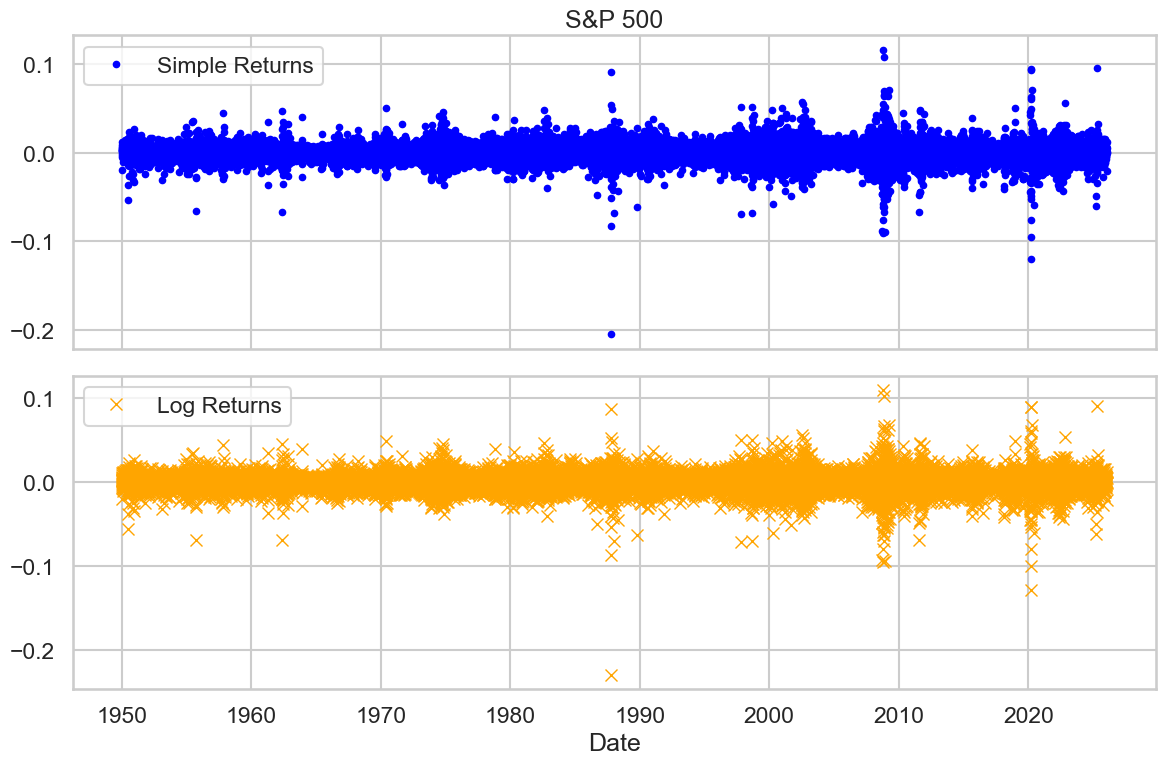

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
ax[0].plot(
    spx_data.index, spx_data["simple_return"], ".", label="Simple Returns", color="blue"
)
ax[0].set_title("S&P 500")
ax[0].legend()
ax[1].plot(
    spx_data.index, spx_data["log_return"], "x", label="Log Returns", color="orange"
)
ax[1].legend()
plt.xlabel("Date")
plt.tight_layout()
plt.show()

We can look at their distributions

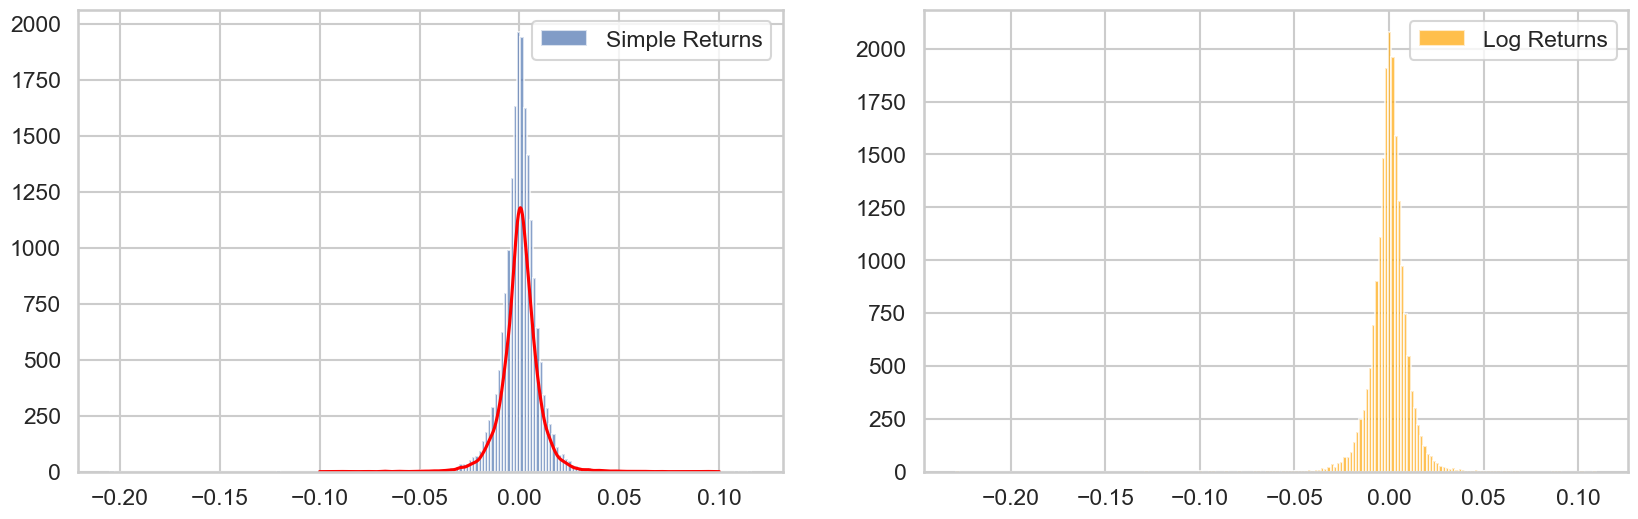

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(2 * 10, 6))
ax[0].hist(spx_data["simple_return"], bins=200, alpha=0.7, label="Simple Returns")
ax[0].legend()
kde = stats.gaussian_kde(spx_data["simple_return"].dropna())
x_vals = np.linspace(-0.1, 0.1, 1000)
ax[0].plot(
    x_vals,
    kde(x_vals) * len(spx_data["simple_return"].dropna()) * (0.2 / 200),
    color="red",
)
ax[1].hist(
    spx_data["log_return"], bins=200, alpha=0.7, label="Log Returns", color="orange"
)
ax[1].legend()
plt.show()

Plot difference between simple and log returns over the period

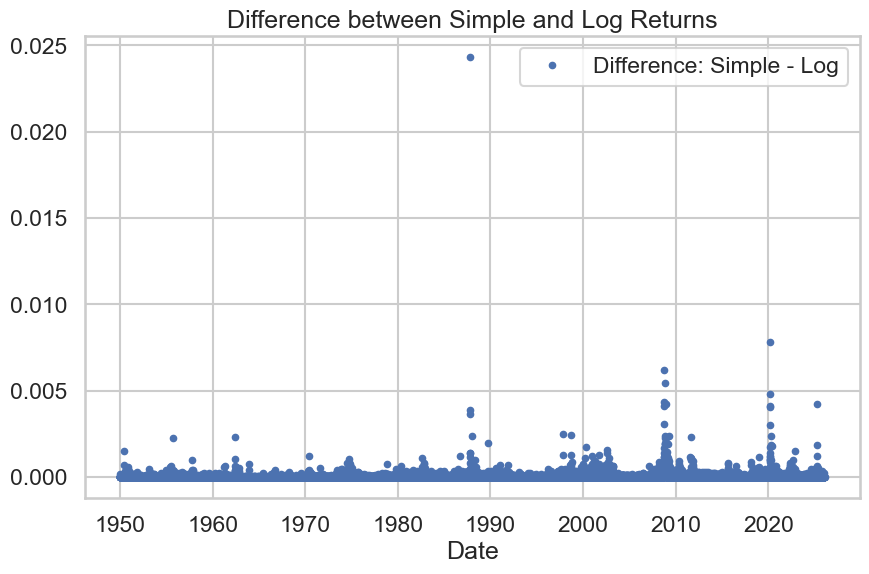

In [20]:
diff_returns = spx_data["simple_return"] - spx_data["log_return"]
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(spx_data.index, diff_returns, ".", label="Difference: Simple - Log")
ax.set_title("Difference between Simple and Log Returns")
ax.legend()
plt.xlabel("Date")
plt.show()

In [21]:
# count number of positive and negative returns

n_positive = (spx_data["log_return"] > 0).sum()
n_negative = (spx_data["log_return"] < 0).sum()
print(
    f"Number of positive returns: {n_positive}. It corresponds to a "
    f"proportion of {n_positive / (n_positive + n_negative):.2%}."
)
print(
    f"Number of negative returns: {n_negative}. It corresponds to a "
    f"proportion of {n_negative / (n_positive + n_negative):.2%}."
)

Number of positive returns: 10170. It corresponds to a proportion of 53.50%.
Number of negative returns: 8840. It corresponds to a proportion of 46.50%.


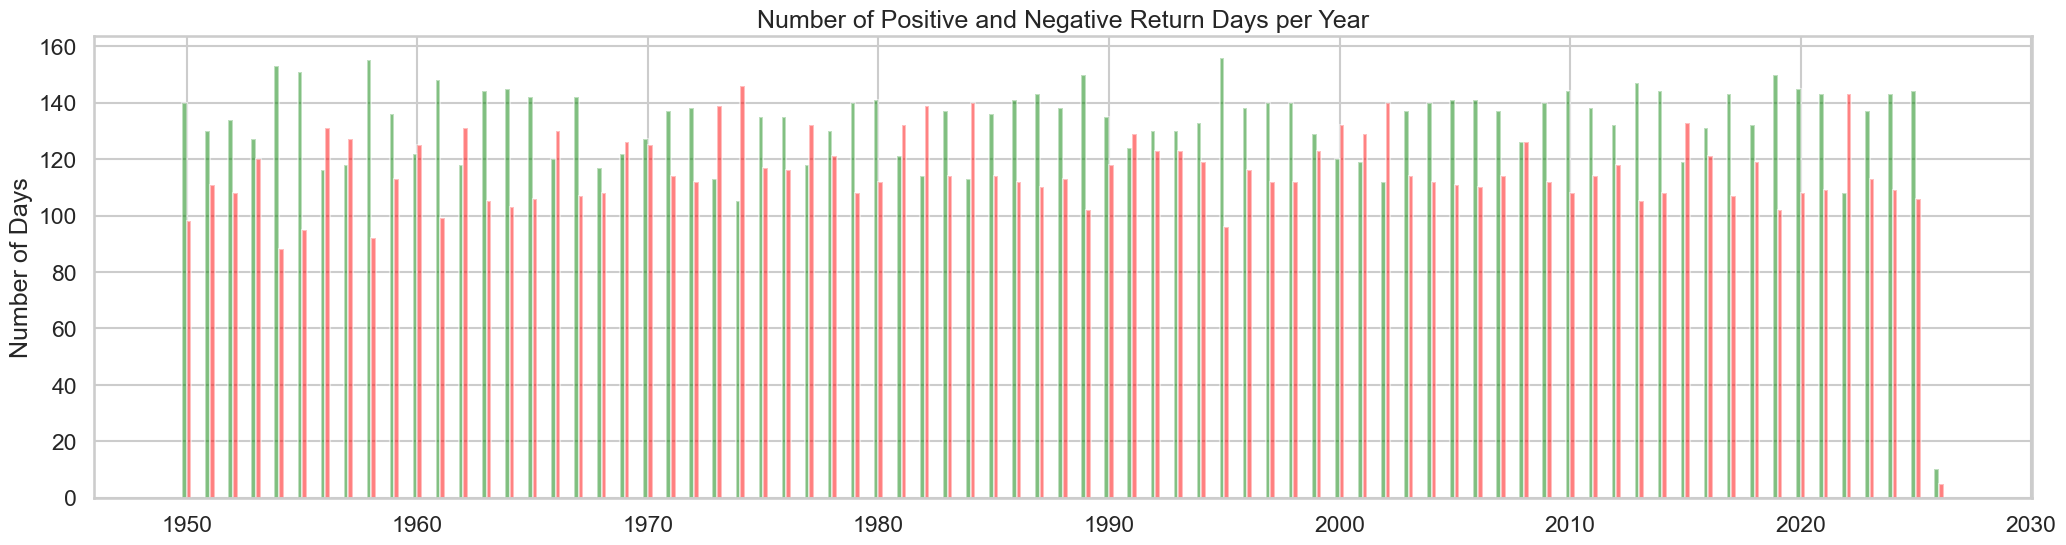

In [22]:
# sample per year
df_pos_neg = (spx_data[["log_return"]] > 0).groupby(spx_data.index.year).sum()
df_pos_neg.columns = ["n_positive_returns"]
df_pos_neg["n_negative_returns"] = (
    (spx_data[["log_return"]] < 0).groupby(spx_data.index.year).sum()
)
df_pos_neg["positive_year"] = (
    df_pos_neg["n_positive_returns"] > df_pos_neg["n_negative_returns"]
)

fig, ax = plt.subplots(figsize=(25, 6))
x = df_pos_neg.index
width = 0.2  # Width of each individual bar

# 2. Plot Positive Bars
ax.bar(
    x - width / 2,
    df_pos_neg["n_positive_returns"],
    width,
    label="Positive Days",
    color="green",
    alpha=0.5,
)

# 3. Plot Negative Bars
ax.bar(
    x + width / 2,
    df_pos_neg["n_negative_returns"],
    width,
    label="Negative Days",
    color="red",
    alpha=0.5,
)
ax.set_ylabel("Number of Days")
ax.set_title("Number of Positive and Negative Return Days per Year")
plt.show()

In [23]:
# 4. Calculate Cumulative Returns
# This shows how $1 invested at the start would have grown
cum_simple_returns = 1 * (1 + spx_data["simple_return"]).cumprod()

# or compute cumulative log returns (gives the same result)
cum_log_returns = np.exp(spx_data["log_return"].cumsum())

# recall that R_t + 1 = exp(r_t) where R_t is simple return and r_t is log return

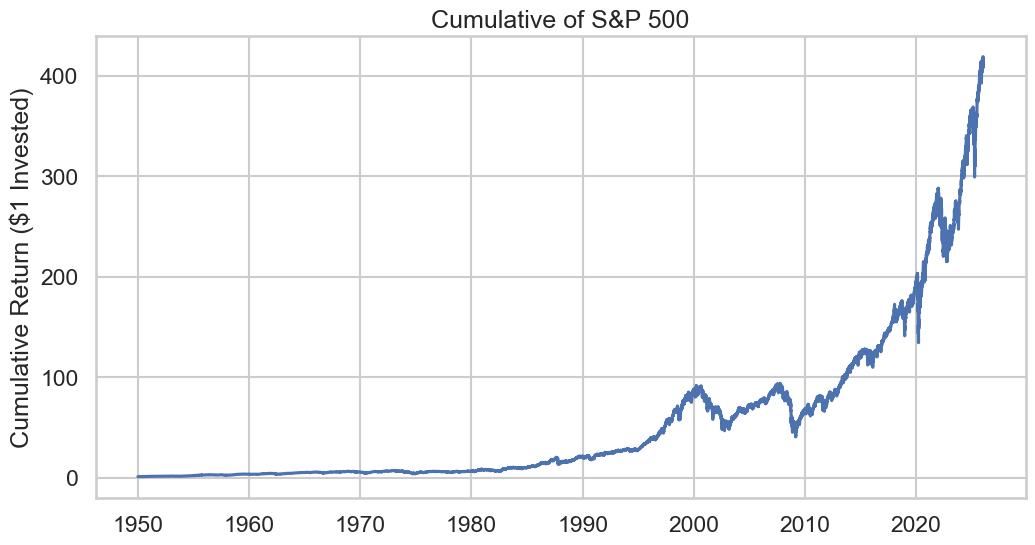

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(spx_data.index, cum_simple_returns)
ax.set_title("Cumulative of S&P 500")
ax.set_ylabel("Cumulative Return ($1 Invested)")
plt.show()

Let us now look at some other variables

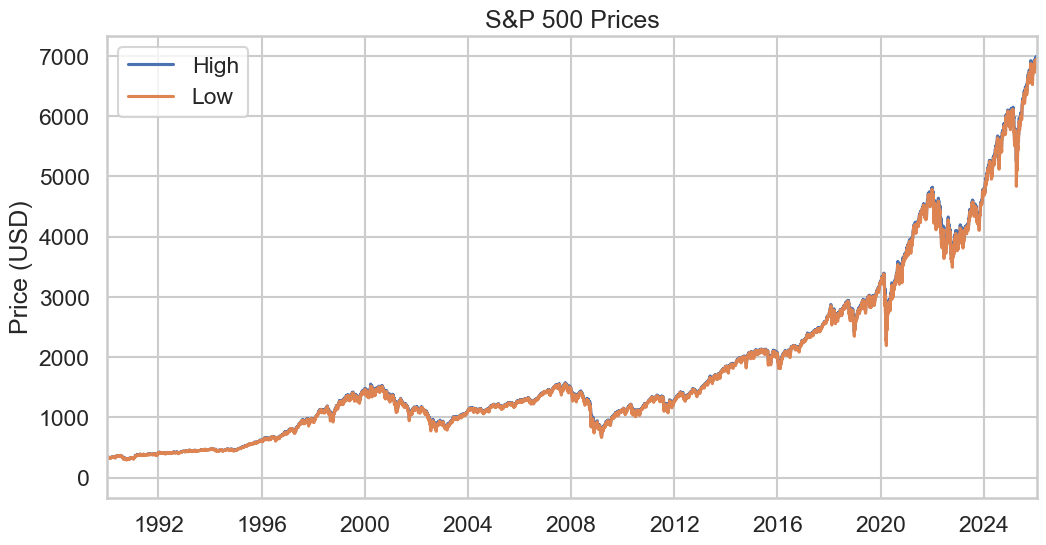

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
for col in ["High", "Low"]:
    ax.plot(spx_data.index, spx_data[col], label=col)
ax.set_title("S&P 500 Prices")
ax.set_ylabel("Price (USD)")
ax.set_xlim(pd.to_datetime("1990-01-01"), spx_data.index[-1])
ax.legend()
plt.show()

Fitting log returns

In [26]:
log_return = spx_data[["log_return"]].dropna()
simple_return = spx_data[["simple_return"]].dropna()

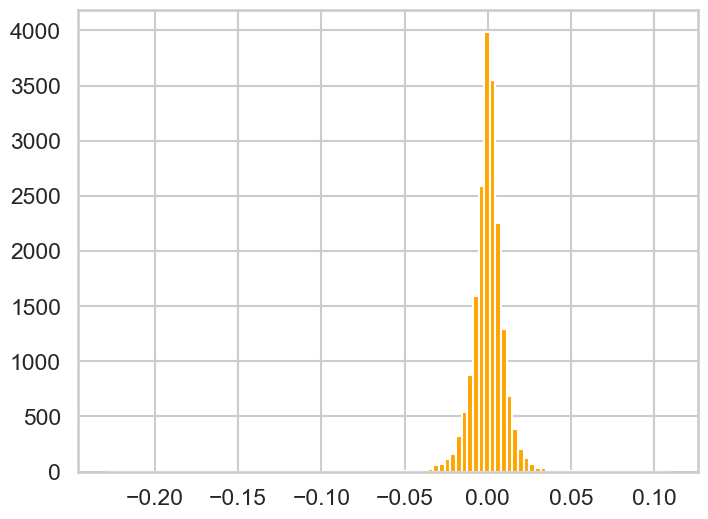

In [27]:
fig, ax = plt.subplots()
ax.hist(log_return, bins=100, label="Log Returns", color="orange")
plt.show()

Normal

In [28]:
norm_loc_mle, norm_scale_mle = stats.norm.fit(log_return, method="mle")
print(f"Normal MLE estimates: loc = {norm_loc_mle}, scale = {norm_scale_mle}")

# check formulas
m = log_return.mean().values[0]
s = np.std(log_return.values, ddof=0)
assert np.isclose(m, norm_loc_mle)
assert np.isclose(s, norm_scale_mle)

Normal MLE estimates: loc = 0.0003150523024241629, scale = 0.009965814815282543


Student

In [29]:
stats.t.fit(log_return, method="mle")
t_df_mle, t_loc_mle, t_scale_mle = stats.t.fit(log_return, method="mle")
print(
    f"Student's t MLE estimates: df = {t_df_mle:.3f}, loc = {t_loc_mle:.3f}, "
    f"scale = {t_scale_mle:.3f}"
)

Student's t MLE estimates: df = 3.045, loc = 0.001, scale = 0.006


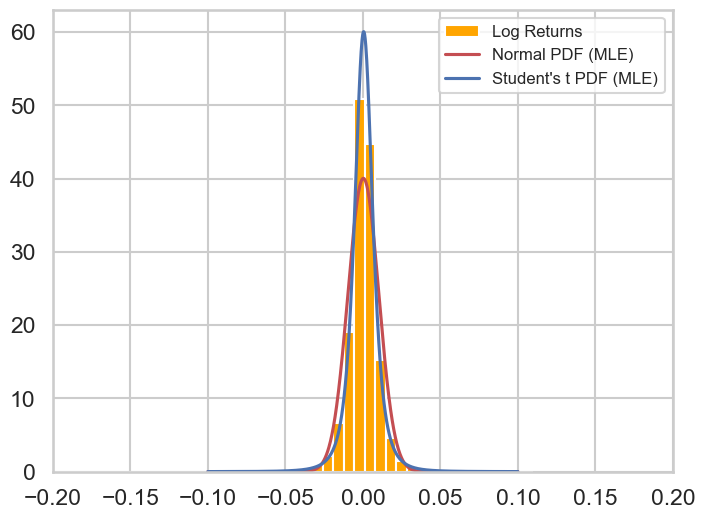

In [30]:
x_vals = np.linspace(-0.1, 0.1, 1000)
pdf_norm = stats.norm.pdf(x_vals, loc=norm_loc_mle, scale=norm_scale_mle)
pdf_t = stats.t.pdf(x_vals, df=t_df_mle, loc=t_loc_mle, scale=t_scale_mle)

fig, ax = plt.subplots()
ax.hist(log_return, bins=50, label="Log Returns", density=True, color="orange")
ax.plot(
    x_vals,
    pdf_norm,
    "r-",
    label="Normal PDF (MLE)",
)
ax.plot(
    x_vals,
    pdf_t,
    "b-",
    label="Student's t PDF (MLE)",
)
ax.set_xlim(-0.2, 0.2)
ax.legend(fontsize=12)
plt.show()

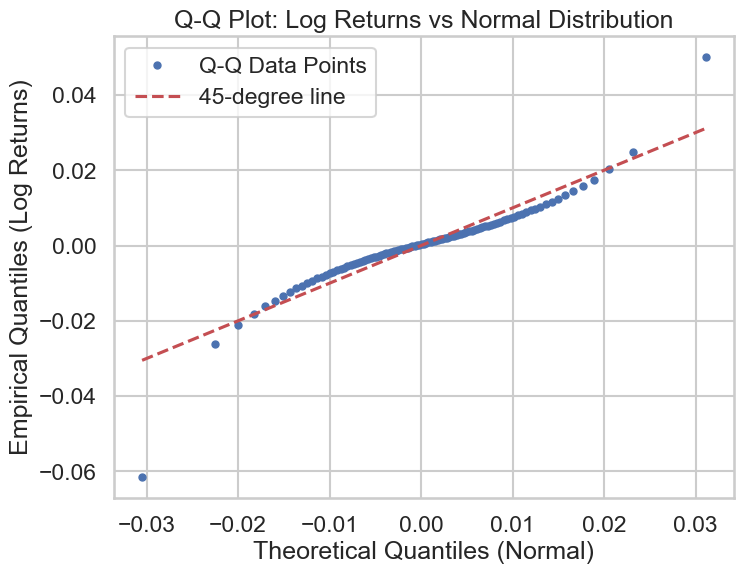

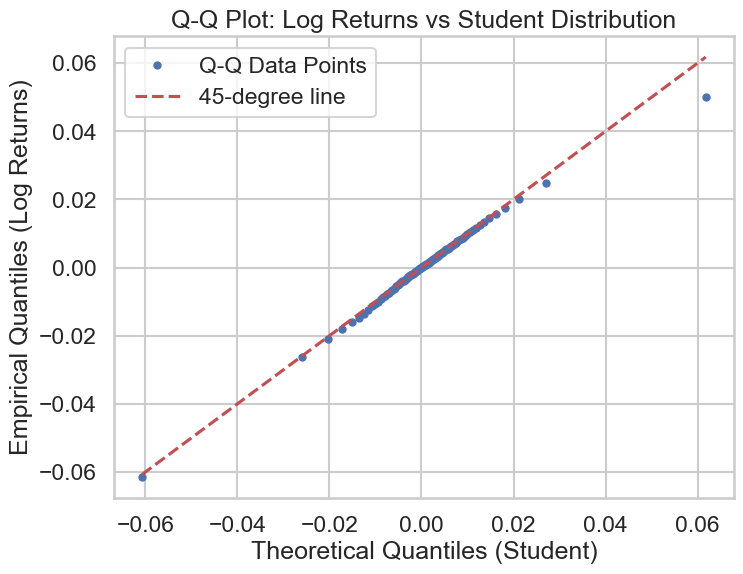

In [31]:
qs = np.linspace(1e-3, 1 - 1e-3, 101)  # quantiles
q_log_returns = np.quantile(log_return, qs)  # empirical quantiles
q_norm = stats.norm.ppf(qs, loc=norm_loc_mle, scale=norm_scale_mle)  # normal quantiles
q_t = stats.t.ppf(qs, df=t_df_mle, loc=t_loc_mle, scale=t_scale_mle)  # t quantiles

fig, ax = plt.subplots()
ax.plot(q_norm, q_log_returns, "bo", markersize=5, label="Q-Q Data Points")
ax.plot(q_norm, q_norm, "r--", label="45-degree line")
ax.set_xlabel("Theoretical Quantiles (Normal)")
ax.set_ylabel("Empirical Quantiles (Log Returns)")
ax.set_title("Q-Q Plot: Log Returns vs Normal Distribution")
ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(q_t, q_log_returns, "bo", markersize=5, label="Q-Q Data Points")
ax.plot(q_t, q_t, "r--", label="45-degree line")
ax.set_xlabel("Theoretical Quantiles (Student)")
ax.set_ylabel("Empirical Quantiles (Log Returns)")
ax.set_title("Q-Q Plot: Log Returns vs Student Distribution")
ax.legend()
plt.show()

## Large moves

In [32]:
import plotly.graph_objects as go

df_large_5_std = (
    100 * simple_return[np.abs(simple_return) > 5 * simple_return.std()].dropna()
)

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_large_5_std.index,
        y=df_large_5_std["simple_return"],
        mode="markers",
        marker={"color": "red", "size": 8},
        name="Returns > 5 Std Dev",
    )
)
fig.update_layout(
    title="Returns exceeding 5 Standard Deviations",
    xaxis_title="Date",
    yaxis_title="Simple Return (%)",
    hovermode="x unified",
    width=1200,
    height=600,
)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Skewness

- Skewness measures the asymmetry of the return distribution.

For a random variable $R$ with mean $\mu$ and standard deviation $\sigma$, 
the skewness is defined as:

$$
    \text{Skewness}(R) 
    = \frac{\mathbb{E}[(R - \mu)^3]}{\sigma^3}
    = \mathbb{E}\left[\left(\frac{R - \mu}{\sigma}\right)^3\right]
$$

Interpretation:
- $\text{Skewness} = 0$:  symmetric distribution.
    - Example: [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) 
- $\text{Skewness} > 0 $: a distribution with a longer right tail (more extreme positive returns).
    - Example: [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution)

- $\text{Skewness} < 0 $: indicates a distribution with a longer left tail (more extreme negative returns).
    - Example: [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) with proper parameters, [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) with proper parameters



In [ ]:
c_weibull = 10.0
stats.weibull_min.stats(c=c_weibull, moments="mvsk")

(np.float64(0.9513507698668734),
 np.float64(0.01310045507346802),
 np.float64(-0.637637133903015),
 np.float64(0.5701664835669136))

In [ ]:
a = 5
b = 2
stats.beta.stats(a=a, b=b, moments="mvsk")

(np.float64(0.7142857142857143),
 np.float64(0.025510204081632654),
 np.float64(-0.5962847939999439),
 np.float64(-0.12))

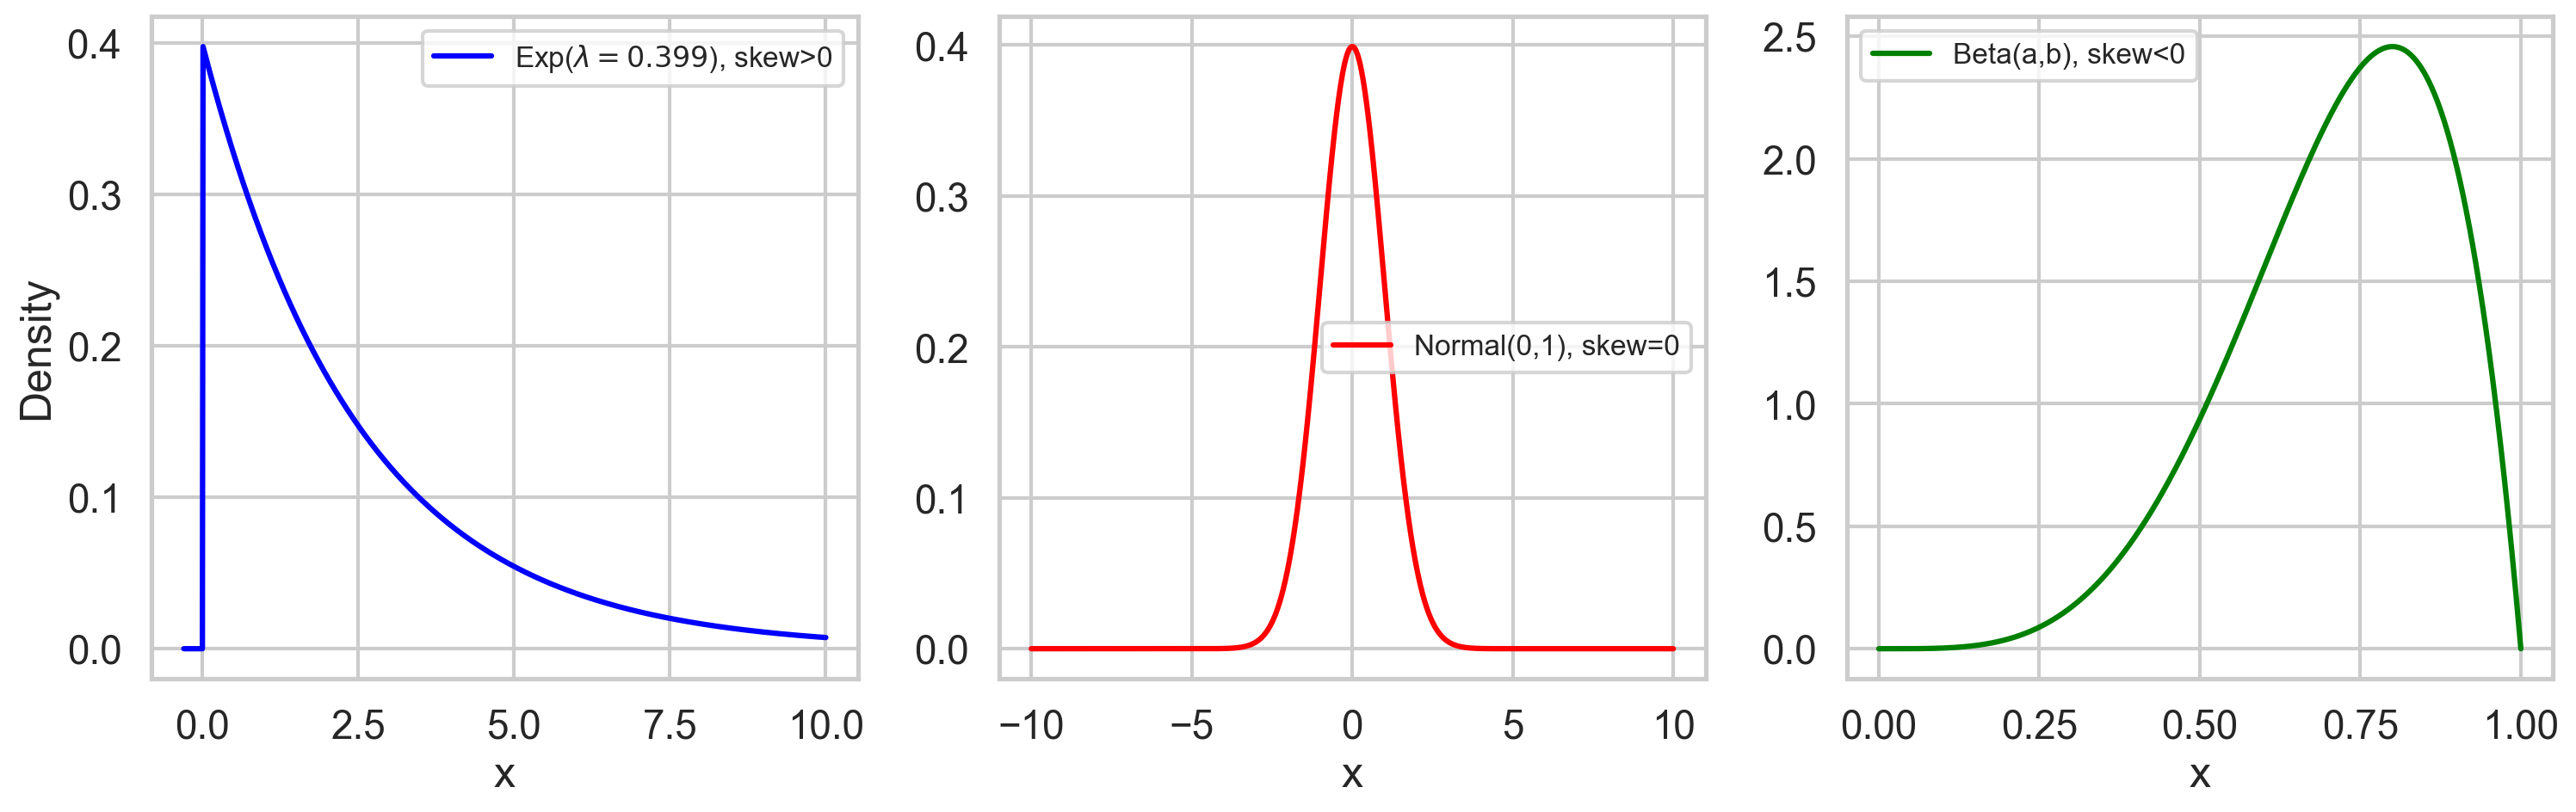

In [ ]:
# skewness > 0
xs_exp = np.linspace(-0.3, 10.0, 1000)
lbd_exp = 1 / np.sqrt(2 * np.pi)
pdf_exp = stats.expon.pdf(xs_exp, scale=1 / lbd_exp)

# skewness < 0
x_beta = np.linspace(0, 1, 1000)
pdf_beta = stats.beta.pdf(x_beta, a=a, b=b)

# skew_ness = 0
xs_norm = np.linspace(-10.0, 10.0, 1000)
mu_norm = 0.0
sigma_norm = 1.0
pdf_norm = stats.norm.pdf(xs_norm, loc=mu_norm, scale=sigma_norm)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
ax[0].plot(
    xs_exp, pdf_exp, "-", color="blue", label=rf"Exp($\lambda={lbd_exp:.3f}$), skew>0"
)
ax[1].plot(xs_norm, pdf_norm, "-", color="red", label="Normal(0,1), skew=0")
ax[2].plot(x_beta, pdf_beta, "-", color="green", label="Beta(a,b), skew<0")
for i in range(3):
    ax[i].set_xlabel("x")
    ax[i].legend(fontsize=12)
ax[0].set_ylabel("Density")
plt.show()

In [ ]:
log_return_skewness = stats.skew(log_return)
print(f"Skewness of S&P 500 log returns: {log_return_skewness[0]:.4f}")

Skewness of S&P 500 log returns: -0.9530


## Kurtosis

Kurtosis measures the "tailedness" of the return distribution.

For a random variable $R$ with mean $\mu$ and standard deviation $\sigma$, the kurtosis is defined as:

$$
    \text{Kurtosis}(R) 
    = \frac{\mathbb{E}[(R - \mu)^4]}{\sigma^4}
    = \mathbb{E}\left[\left(\frac{R - \mu}{\sigma}\right)^4\right]
$$

Interpretation:
- $\text{Kurtosis} = 3$: mesokurtic distribution (normal distribution).
- $\text{Kurtosis} > 3$: leptokurtic distribution (fat tails, more extreme events).
- $\text{Kurtosis} < 3$: platykurtic distribution (thin tails, fewer extreme events).

Excess Kurtosis:
- Defined as $\text{Excess Kurtosis} = \text{Kurtosis} - 3$.
- Helps to compare the kurtosis of a distribution to that of a normal distribution.

In [ ]:
log_return_kurtosis = stats.kurtosis(log_return)
print(f"Kurtosis of S&P 500 log returns: {log_return_kurtosis[0]:.4f}")

Kurtosis of S&P 500 log returns: 25.2808


In [ ]:
# remove extreme values beyond 5 standard deviations
filtered_kurtosis = log_return[np.abs(log_return) < 5 * log_return.std()].kurtosis()
print(
    f"Kurtosis of S&P 500 log returns (filtered): {filtered_kurtosis.to_numpy()[0]:.4f}"
)

Kurtosis of S&P 500 log returns (filtered): 3.1377


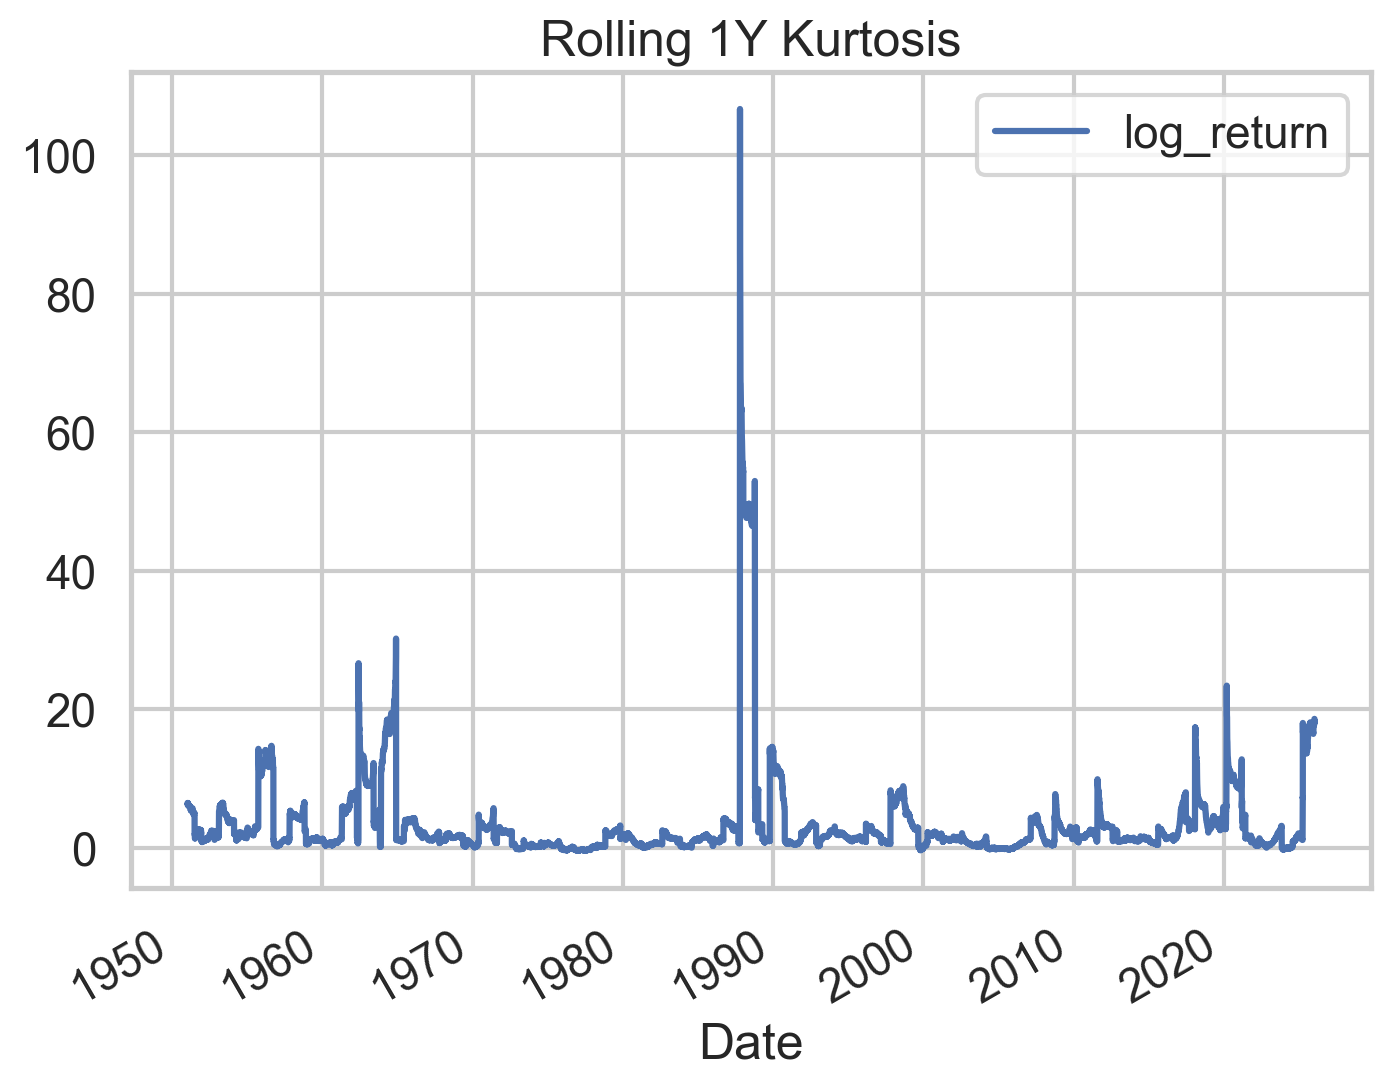

In [ ]:
# rolling kurtosis to show crises
log_return.rolling(252).kurt().plot(title="Rolling 1Y Kurtosis");

In [ ]:
# aggregate to weekly and monthly frequency
# we see that kurtosis decreases with lower frequency
log_return_week = log_return.resample("W").sum()
log_return_month = log_return.resample("ME").sum()

for x, name in [
    (log_return, "daily"),
    (log_return_week, "weekly"),
    (log_return_month, "monthly"),
]:
    print(f"{name}: {stats.kurtosis(x)[0]:.4f}")

daily: 25.2808
weekly: 6.1895
monthly: 2.1919


## Autocorrelation

Let $(R_t)$ be a (weakly) stationary time series of returns, i.e., its mean, variance, and autocovariances do not depend on time.

The autocorrelation at lag $k$ is defined as

$$
    \rho(k) 
    = \frac{\mathbb{E}[(R_t - \mu)(R_{t-k} - \mu)]}{\sigma^2}
    = \mathbb{E}\left[\left(\frac{R_t - \mu}{\sigma}\right)\left(\frac{R_{t-k} - \mu}{\sigma}\right)\right].
$$

The sample autocorrelation function (ACF) is given by

$$
    \hat{\rho}(k) 
    = \frac{\sum_{t=k+1}^T (R_t - \bar{R})(R_{t-k} - \bar{R})}{\sum_{t=1}^T (R_t - \bar{R})^2}.
$$

- Returns typically exhibit little to no autocorrelation: $\rho(k) \approx 0$ for $k \geq 1$.
- However, squared or absolute returns often show significant positive autocorrelation, indicating volatility clustering:
$$
    \text{Corr}(R_t^2, R_{t-k}^2) > 0 \quad \text{for } k \geq 1.
$$

<span style="color:blue">**Volatility Clustering:**</span> Large returns (positive or negative) tend to be followed by large returns, and small returns tend to be followed by small returns.


<Figure size 1000x500 with 0 Axes>

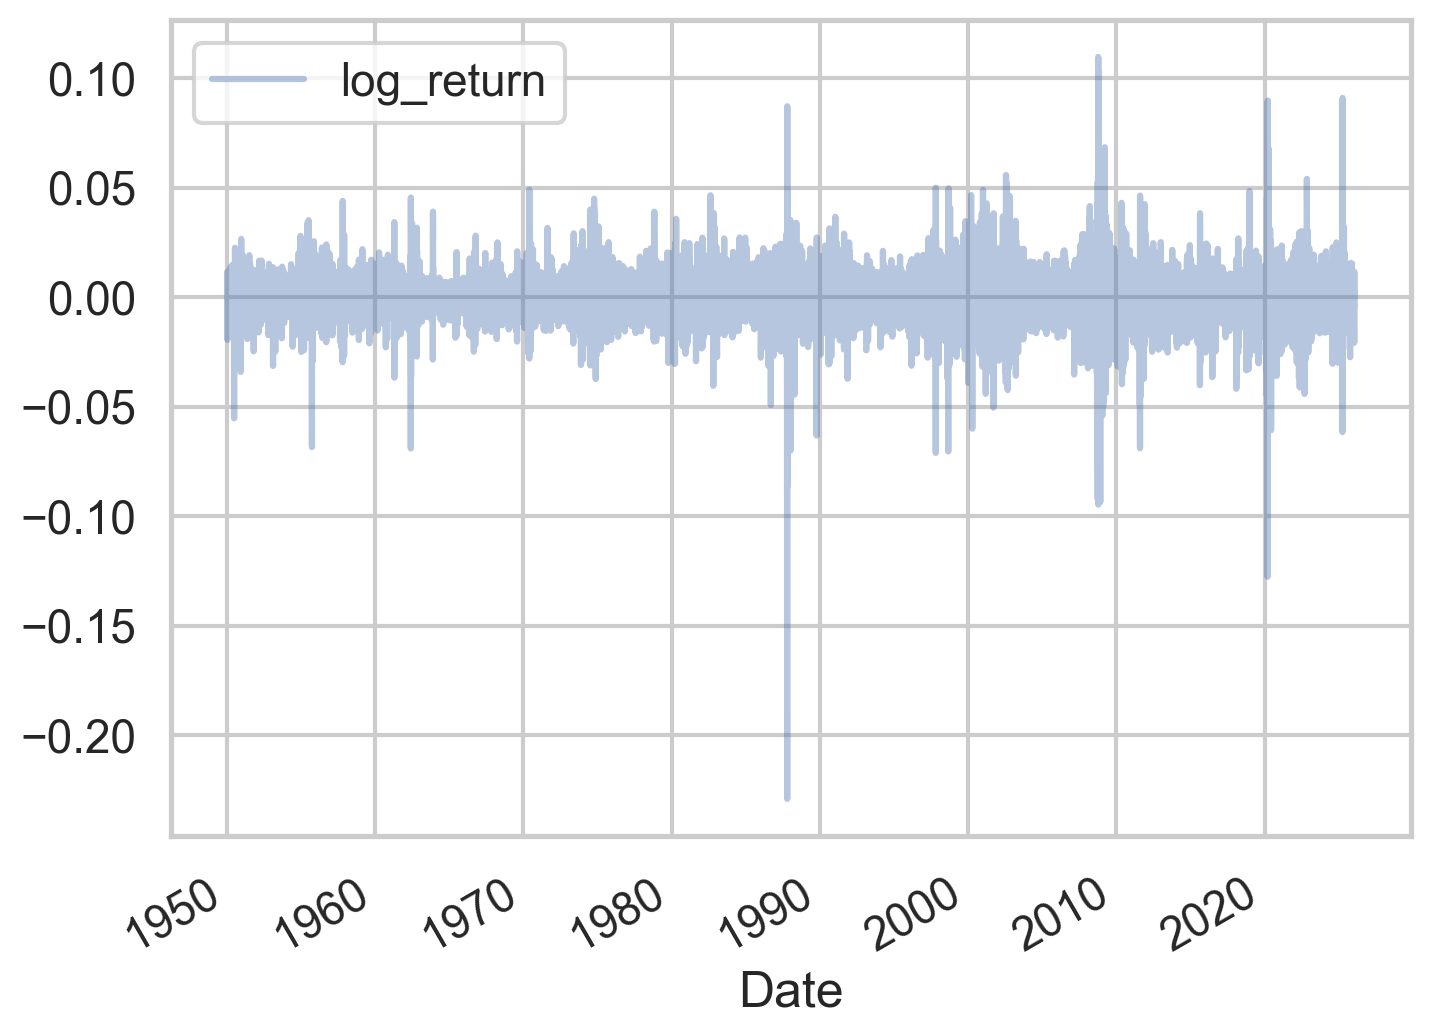

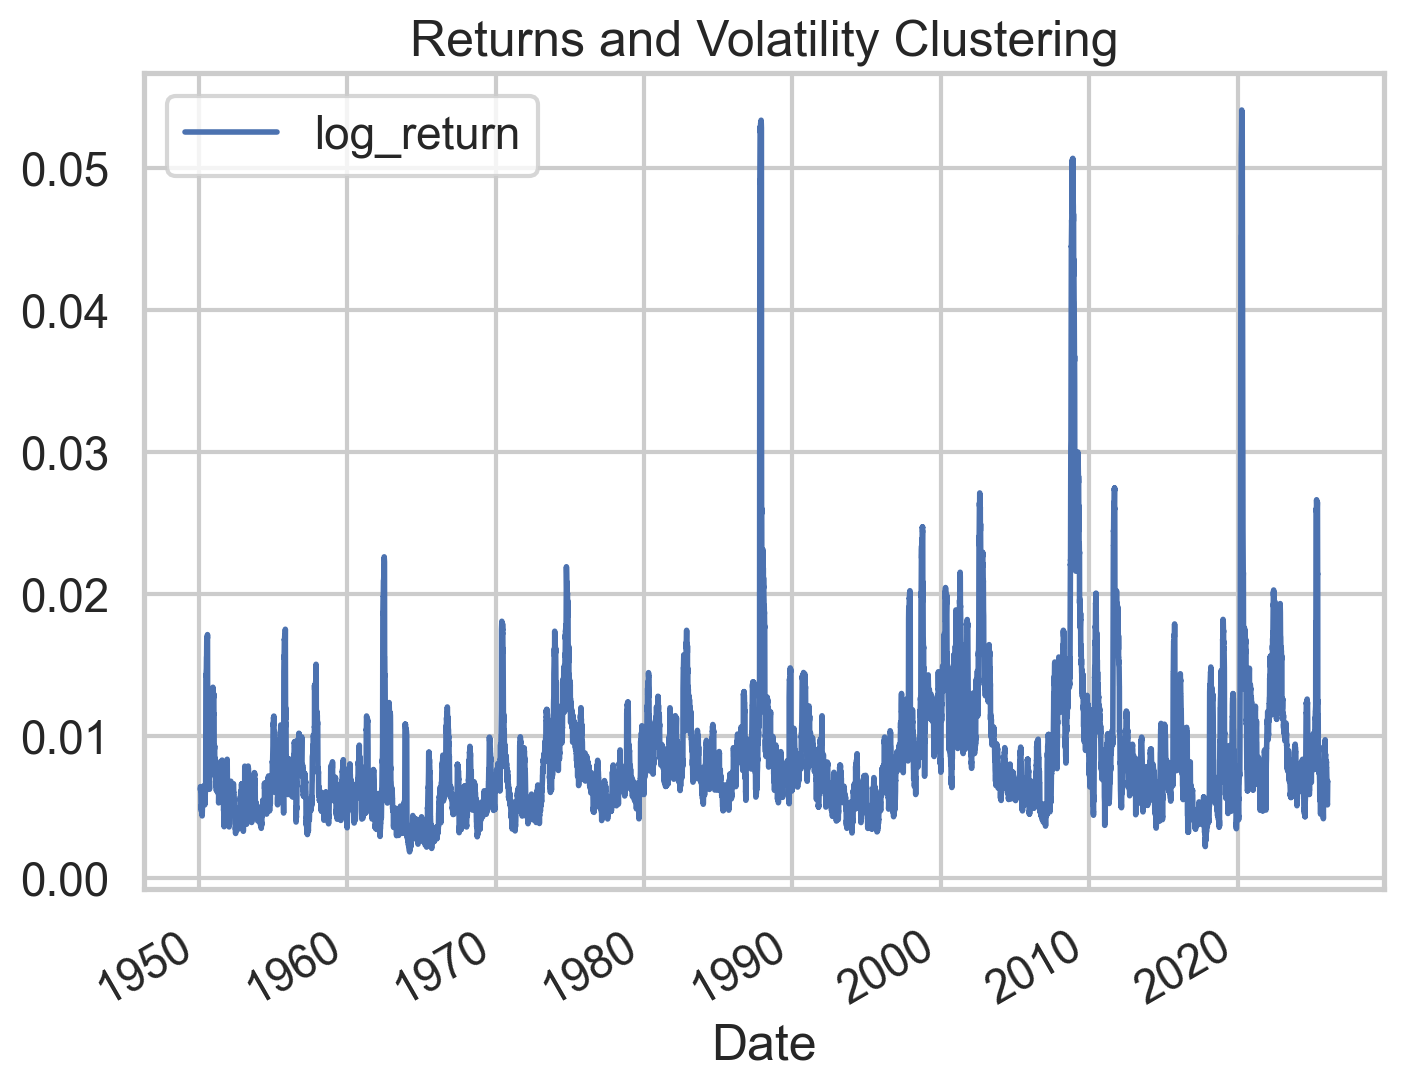

In [ ]:
plt.figure(figsize=(10, 5))
log_return.plot(alpha=0.4, label="Returns")
log_return.rolling(30).std().plot(label="30d rolling vol", lw=2)
plt.legend()
plt.title("Returns and Volatility Clustering")
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

ACF of returns (almost no autocorrelation)

<Figure size 800x400 with 0 Axes>

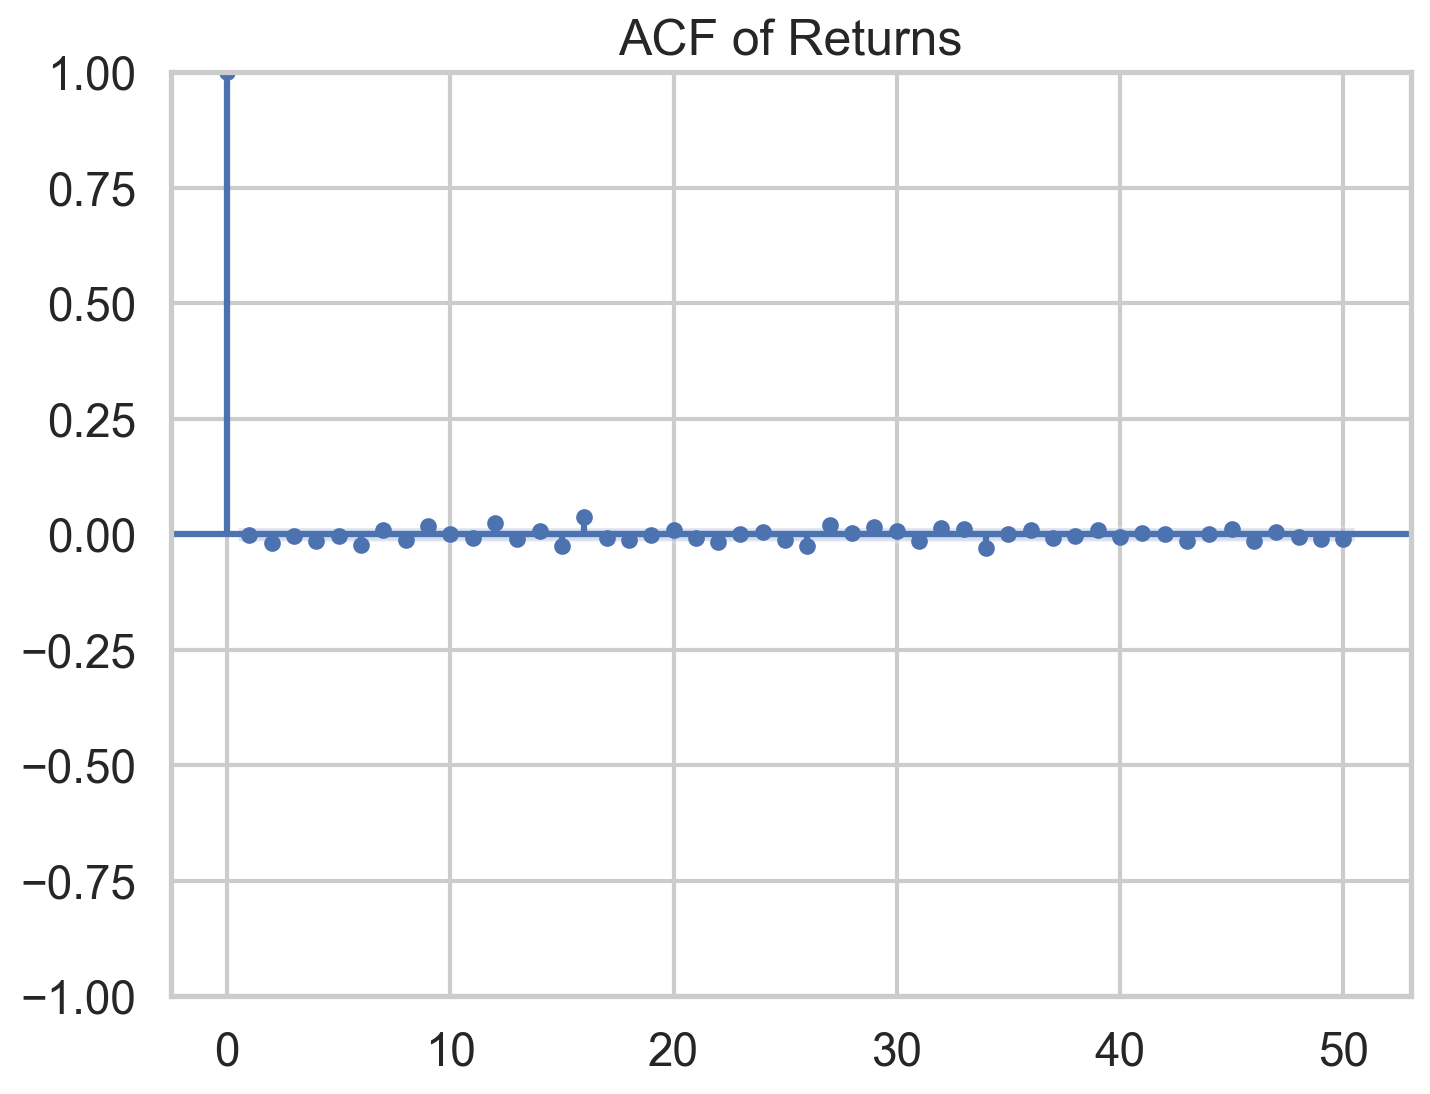

In [ ]:
plt.figure(figsize=(8, 4))
plot_acf(log_return, lags=50)
plt.title("ACF of Returns")
plt.show()

ACF of squared returns (significant autocorrelation)

<Figure size 800x400 with 0 Axes>

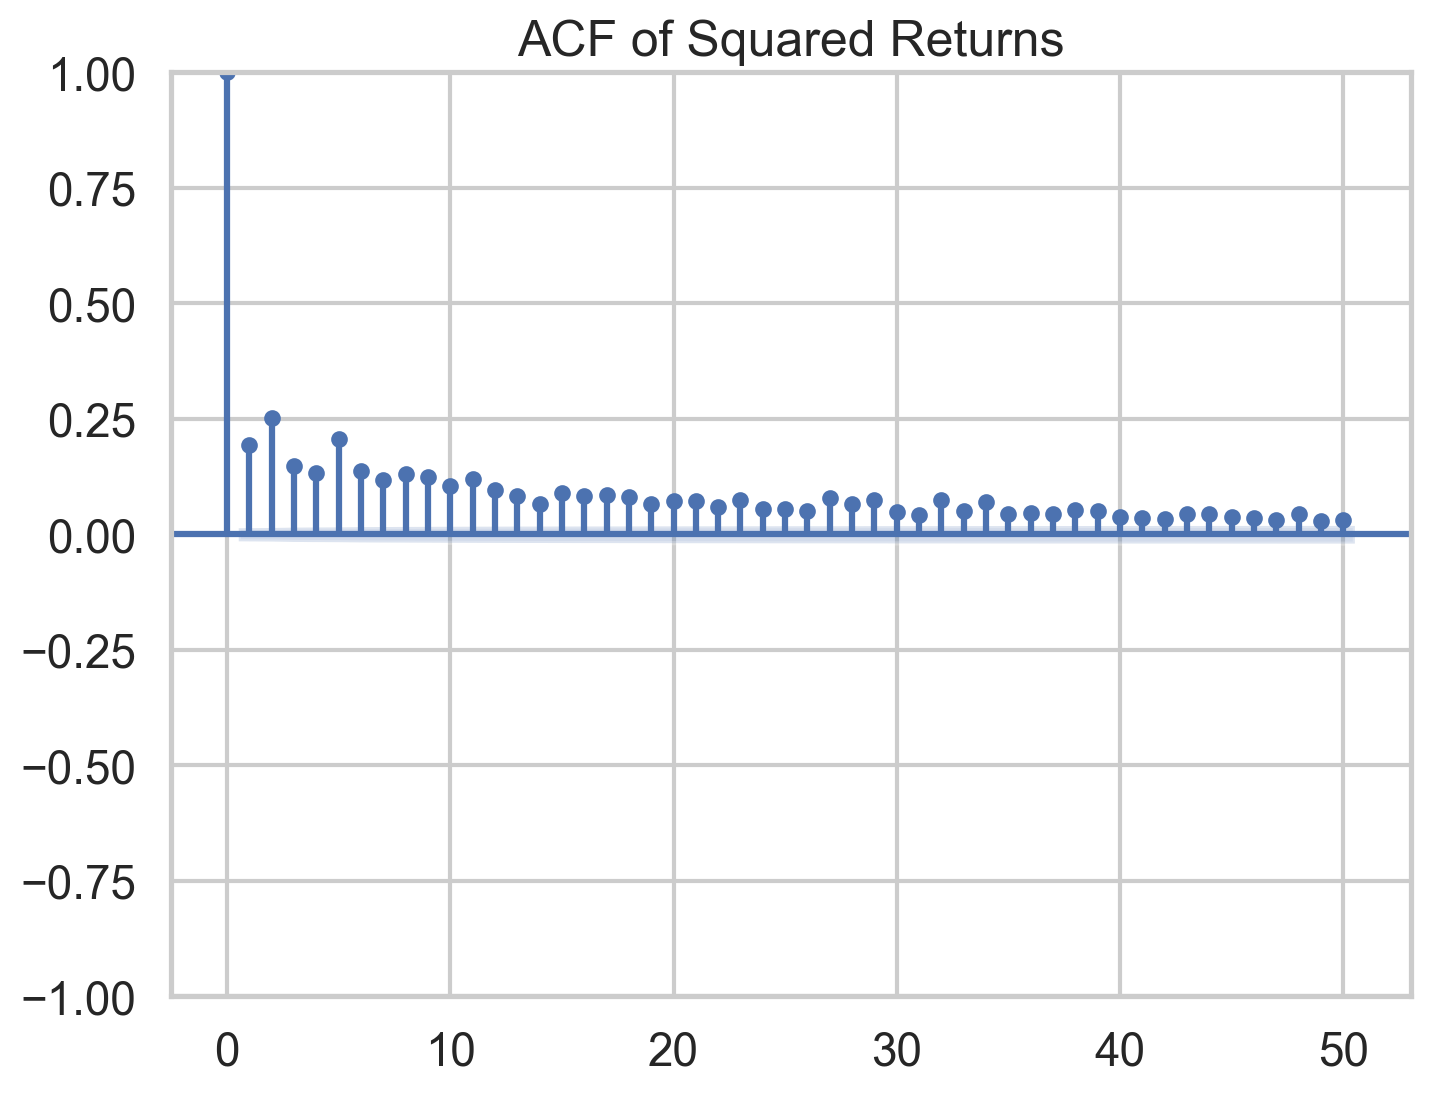

In [ ]:
plt.figure(figsize=(8, 4))
plot_acf(log_return**2, lags=50)
plt.title("ACF of Squared Returns")
plt.show()